In [39]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import SamModel, SamProcessor
import time

def pca_color_feature(feature_map, n_components=3):
    """
    Apply PCA to a feature map and reduce it to n_components (3 for RGB).

    Parameters:
      feature_map: a torch.Tensor of shape (channels, height, width)
      n_components: the number of PCA components (default is 3)

    Returns:
      A normalized image tensor of shape (height, width, n_components) with values in [0, 1].
    """
    # Rearrange feature_map to shape (height, width, channels)
    fm = feature_map.permute(1, 2, 0)   # (H, W, C)
    H, W, C = fm.shape

    # Flatten the spatial dimensions: shape -> (H*W, C)
    fm_flat = fm.reshape(-1, C)
    
    # Compute PCA using torch.pca_lowrank, reducing to n_components.
    # This returns U, S, V such that fm_flat ≈ U @ diag(S) @ V.T
    U, S, V = torch.pca_lowrank(fm_flat, q=n_components)
    
    # Project the flattened feature vectors onto the PCA space using V.
    # V has shape (n_components, C). The projection is given by:
    reduced = torch.matmul(fm_flat, V)  # shape: (H*W, n_components)
    
    # Reshape the reduced features back to (H, W, n_components)
    reduced = reduced.reshape(H, W, n_components)
    
    # Normalize each PCA channel to [0, 1] for display.
    flat_reduced = reduced.reshape(-1, n_components)
    min_vals = flat_reduced.min(dim=0)[0]
    max_vals = flat_reduced.max(dim=0)[0]
    normalized = (reduced - min_vals) / (max_vals - min_vals + 1e-5)

    return normalized

def display_edges_with_pca(image_path):
    """
    Load an image from disk, extract a feature map via SAM's image encoder,
    and use PCA to reduce the features to 3 channels (RGB). The result
    highlights edges and high-variance features.
    
    Parameters:
      image_path (str): Path to a jpg or png image.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load the SAM model and processor.)
    model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
    processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
    
    # Load the image and convert it to RGB.
    raw_image = Image.open(image_path).convert("RGB")
    
    start_time = time.time()
    print("time start: ", start_time)
    # Process the image using the processor.
    # Note: Instead of calling 'processor.preprocess', we directly call the processor.
    inputs = processor(raw_image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Extract a feature map using the image encoder.
    with torch.no_grad():
        feature_map = model.get_image_embeddings(inputs["pixel_values"])
    
    # Assume the output has shape (B, C, H, W); take the first image in the batch.
    feature_map = feature_map[0]  # shape: (C, H, W)
    
    # Apply PCA to the feature map to reduce it to 3 channels.
    pca_result = pca_color_feature(feature_map)  # shape: (H, W, 3)
    print("time taken: ", time.time() - start_time)
    
    # Display the PCA-reduced feature map.
    plt.figure(figsize=(10, 10))
    plt.imshow(pca_result.cpu().detach().numpy())
    plt.title("PCA Reduced Feature Map (Edges Emphasized)")
    plt.axis("off")
    plt.show()

# Example usage:
# Replace the path below with the location of your local image.
# display_edges_with_pca("path/to/your/image.jpg")

time start:  1744565365.4930747
time taken:  0.32704687118530273


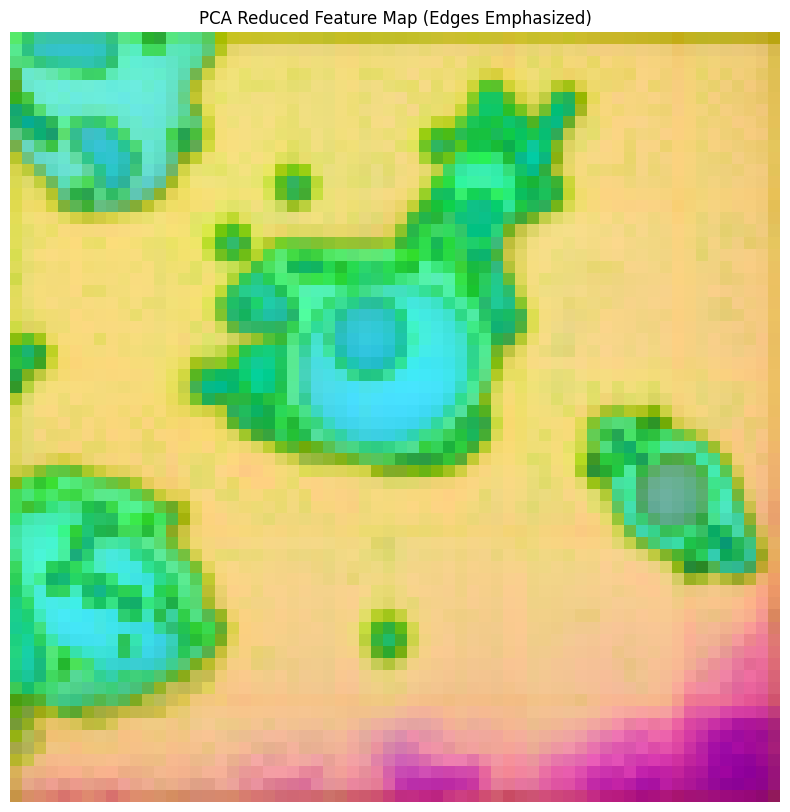

In [40]:
display_edges_with_pca("/workspace/dslab25/training/vacuum_pump/images/original/stage_0/stage_0_var_1_case_render_8.jpg")
# segment_image_with_all_masks("path/to/your/image.jpg", segmentation_map_path="path/to/segmentation_map.png")

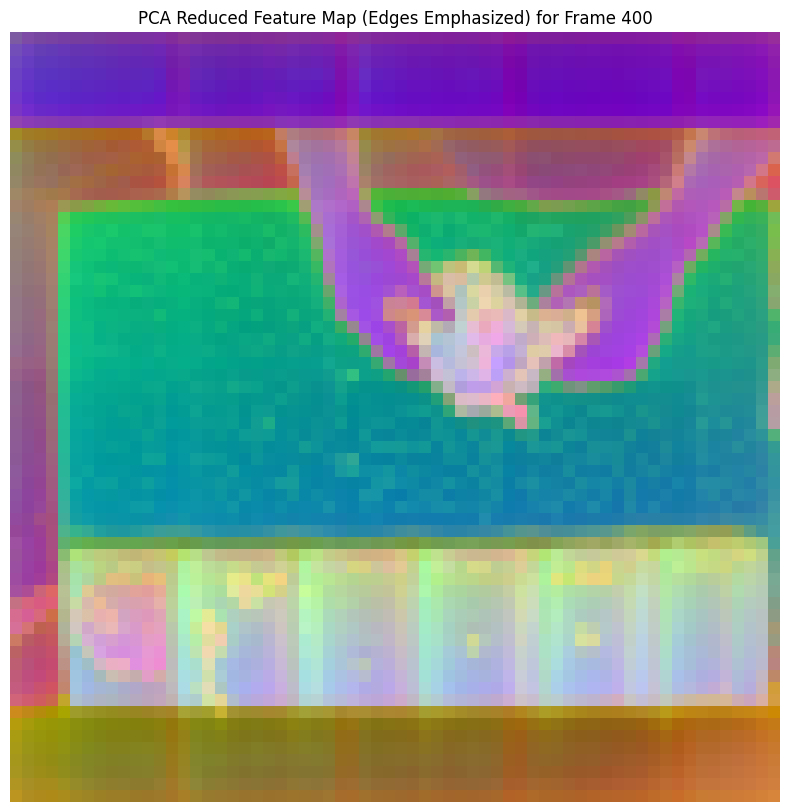

In [45]:
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import SamModel, SamProcessor

def pca_color_feature(feature_map, n_components=3):
    """
    Apply PCA to a feature map and reduce it to n_components (3 for RGB).
    
    Parameters:
      feature_map: a torch.Tensor of shape (channels, height, width)
      n_components: the number of PCA components (default is 3)
      
    Returns:
      A normalized image tensor of shape (height, width, n_components) with values in [0, 1].
    """
    # Rearrange feature_map to shape (H, W, C)
    fm = feature_map.permute(1, 2, 0)  # shape: (H, W, C)
    H, W, C = fm.shape

    # Flatten the spatial dimensions: shape -> (H*W, C)
    fm_flat = fm.reshape(-1, C)
    
    # Compute PCA using torch.pca_lowrank, reducing to n_components.
    # This returns U, S, V such that fm_flat ≈ U @ diag(S) @ V.T.
    U, S, V = torch.pca_lowrank(fm_flat, q=n_components)
    
    # V has shape (C, n_components), so project by multiplying X @ V.
    reduced = torch.matmul(fm_flat, V)  # shape: (H*W, n_components)
    
    # Reshape back to (H, W, n_components).
    reduced = reduced.reshape(H, W, n_components)
    
    # Normalize each channel to the range [0, 1].
    flat_reduced = reduced.reshape(-1, n_components)
    min_vals = flat_reduced.min(dim=0)[0]
    max_vals = flat_reduced.max(dim=0)[0]
    normalized = (reduced - min_vals) / (max_vals - min_vals + 1e-5)
    
    return normalized

def process_video_frame(video_path, target_frame_idx=1000):
    """
    Reads the target_frame_idx-th frame from a video file, uses SAM's image encoder to
    obtain a feature map, applies PCA to reduce it to 3 channels (RGB), and displays the
    result.

    Parameters:
      video_path (str): Path to the video file.
      target_frame_idx (int): Index of the frame to process (default is 1000).
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Open the video and iterate until we reach the target frame.
    cap = cv2.VideoCapture(video_path)
    current_idx = 0
    target_frame = None
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if current_idx == target_frame_idx:
            target_frame = frame
            break
        current_idx += 1
    cap.release()
    
    if target_frame is None:
        print(f"Frame {target_frame_idx} was not found in the video.")
        return
    
    # Convert the frame from BGR (OpenCV) to RGB and create a PIL Image.
    frame_rgb = cv2.cvtColor(target_frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(frame_rgb)
    
    # Load the SAM model and processor.
    model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
    processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
    
    # Process the image. Instead of a .preprocess method, we simply call the processor.
    inputs = processor(image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Extract the feature map using the image encoder.
    with torch.no_grad():
        feature_map = model.get_image_embeddings(inputs["pixel_values"])
        
    # SAM's image encoder outputs a tensor with shape (B, C, H, W).
    feature_map = feature_map[0]  # Use the first image in the batch.
    
    # Apply PCA to the feature map.
    pca_result = pca_color_feature(feature_map)  # shape: (H, W, 3)
    
    # Display the result.
    plt.figure(figsize=(10, 10))
    plt.imshow(pca_result.cpu().detach().numpy())
    plt.title(f"PCA Reduced Feature Map (Edges Emphasized) for Frame {target_frame_idx}")
    plt.axis("off")
    plt.show()

# Example usage:
# Replace 'path/to/your/video.mp4' with the path to your video file.
# This will process the 1000th frame of the video.
process_video_frame("/workspace/dslab25/assets/vacuum_pump/videos/01_run1_cam_2_1024x1024_15fps_3mbps.mp4", target_frame_idx=400)